In [175]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
import random

In [176]:
# --- Load Data ---
csv_file = '../Datasets/2_SENSEX_ClassificationFalse.csv'
df = pd.read_csv(csv_file)

# --- Add lag features ---
close_times = df['close_time'].values
labels = df['label'].values
times = df['time'].values
for lag in range(1, 11):
    lag_labels = [None] * len(df)
    last_valid_indices = []
    j = 0
    for i in range(len(df)):
        while j < len(df) and close_times[j] < times[i]:
            last_valid_indices.append(j)
            j += 1
        if len(last_valid_indices) >= lag:
            lag_labels[i] = labels[last_valid_indices[-lag]]
        else:
            lag_labels[i] = None
    df[f'label_lag_{lag}'] = lag_labels

feature_columns = ['close', 'SD', 'upper', 'mid', 'lower', 'stock_position'] + [f'label_lag_{i}' for i in range(1, 11)]



In [177]:
# --- Trading Simulation Function ---
def simulate_trading_strategy(test_df, prediction_func):
    """
    Simulate a trading strategy on test_df using prediction_func.
    prediction_func should take a row (Series) and return 1 (take trade as is) or 0 (take opposite).
    Returns: profits, times, total_profit, trade_count
    """
    trades = test_df[(test_df['stock_position'].isin([2, -2]))].sort_values('time')
    profits = []
    times = []
    total_profit = 0
    trade_count = 0
    last_exit_time = 500
    end_time = 30000

    for idx, row in trades.iterrows():
        entry_time = row['time']
        exit_time = row['close_time']
        if entry_time > end_time:
            break
        if pd.isna(entry_time) or pd.isna(exit_time):
            continue
        if entry_time >= last_exit_time:
            pred = prediction_func(row)
            profit = row['expected_profit'] if pred == 1 else -row['expected_profit']
            total_profit += profit
            trade_count += 1
            profits.append(total_profit)
            times.append(entry_time)
            last_exit_time = exit_time
        

    return profits, times, total_profit, trade_count


In [178]:
# --- Example prediction functions ---

# baseline
def baseline(row):
    return 1

# Majority vote on previous ... label lags
def majority_vote(row):
    lags = [row[f'label_lag_{j}'] for j in range(1, 9)]
    lags = [x for x in lags if x in [0, 1]]
    if len(lags) == 0:
        return 1
    
    # count = sum(x for x in lags)
    # return 1 if count > 0 else 0
    
    count_ones = sum(1 for x in lags if x == 1)
    count_zeros = sum(1 for x in lags if x == 0)
    return 1 if count_ones > count_zeros else 0

# Do the exact opposite of the previous trade
def opposite_prev(row):
    if row.get('label_lag_1') == 0:
        return 1
    else:
        return 0


def random_guess(row):
    n = random.randint(0, 1)
    return n

# Rolling XGBoost retrain prediction function
def rolling_xgb_predictor(df, feature_columns, train_window=1000, retrain_interval=500):
    """
    Returns a prediction function that retrains XGBoost every `retrain_interval` minutes using the previous `train_window` minutes.
    The returned function can be used as prediction_func in simulate_trading_strategy.
    """
    # Precompute model checkpoints
    checkpoints = []
    times = df['time'].values
    min_time = times.min()
    max_time = times.max()
    current_time = min_time + train_window

    while current_time <= max_time:
        train_start = current_time - train_window
        train_end = current_time
        train_df = df[(df['time'] >= train_start) & (df['time'] < train_end)]
        train_df_filtered = train_df[(train_df['stock_position'].isin([2, -2])) & (train_df['label'].isin([0, 1]))]
        X_train = train_df_filtered[feature_columns]
        y_train = train_df_filtered['label']
        if len(X_train) > 0 and len(np.unique(y_train)) > 1:
            # model = XGBClassifier(eval_metric='mlogloss', max_depth=5, min_child_weight=3, n_estimators=250, use_label_encoder=False, verbosity=0, eta=0.01)
            model = XGBClassifier(n_estimators=250, use_label_encoder=False, eval_metric='logloss', verbosity=0, eta = 0.01, )
            # model = XGBClassifier(
            #     n_estimators=300,
            #     max_depth=5,
            #     min_child_weight=3,
            #     subsample=0.8,
            #     colsample_bytree=0.8,
            #     eta=0.01,
            #     reg_alpha=0.1,
            #     reg_lambda=1,
            #     use_label_encoder=False,
            #     eval_metric='logloss',
            #     verbosity=0
            # )
            model.fit(X_train, y_train)
            checkpoints.append((current_time, model))
        current_time += retrain_interval

    def pred_func(row):
        # Find the latest checkpoint before row['time']
        row_time = row['time']
        idx = np.searchsorted([cp[0] for cp in checkpoints], row_time, side='right') - 1
        if idx < 0:
            # Not enough history, fallback to always take trade
            return 1
        model = checkpoints[idx][1]
        X_pred = row[feature_columns].values.reshape(1, -1)
        return model.predict(X_pred)[0]

    return pred_func


In [190]:
# --- Run all strategies ---

# Baseline
profits_baseline, times_baseline, total_profit_baseline, trade_count_baseline = simulate_trading_strategy(df, baseline)
print(f"Baseline: Total simulated profit: {total_profit_baseline:.2f}, Number of trades: {trade_count_baseline}")

# Majority Vote
profits_majority, times_majority, total_profit_majority, trade_count_majority = simulate_trading_strategy(df, majority_vote)
print(f"Majority Vote: Total simulated profit: {total_profit_majority:.2f}, Number of trades: {trade_count_majority}")

# Random Guess
profits_random, times_random, total_profit_random, trade_count_random = simulate_trading_strategy(df, random_guess)
print(f"Random Guess: Total simulated profit: {total_profit_random:.2f}, Number of trades: {trade_count_random}")

# Opposite of the previous trade
# profits_opp, times_opp, total_profit_opp, trade_count_opp = simulate_trading_strategy(df, opposite_prev)
# print(f"Opposite: Total simulated profit: {total_profit_opp:.2f}, Number of trades: {trade_count_opp}")

# Rolling XGBoost
# rolling_pred_func = rolling_xgb_predictor(df, feature_columns, train_window=500, retrain_interval=250)
# profits_xgb, times_xgb, total_profit_xgb, trade_count_xgb = simulate_trading_strategy(df, rolling_pred_func)
# print(f"Rolling XGB: Total simulated profit: {total_profit_xgb:.2f}, Number of trades: {trade_count_xgb}")


Baseline: Total simulated profit: -4.69, Number of trades: 916
Majority Vote: Total simulated profit: -3.28, Number of trades: 916
Random Guess: Total simulated profit: 0.71, Number of trades: 916


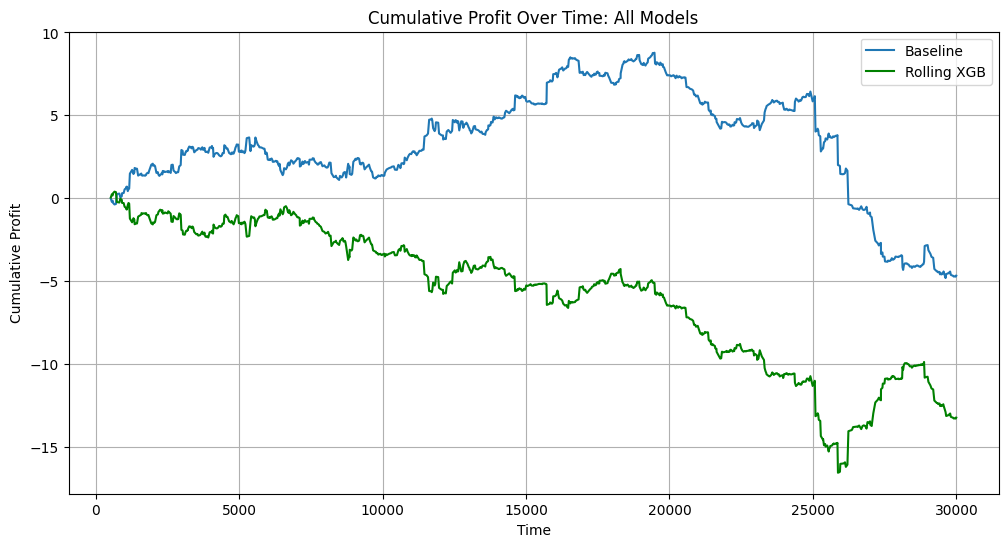

In [193]:
# --- Plot Comparison ---
plt.figure(figsize=(12, 6))
plt.plot(times_baseline, profits_baseline, label='Baseline')
# plt.plot(times_majority, profits_majority, label='Majority Vote')
plt.plot(times_xgb, profits_xgb, label='Rolling XGB', color = 'green')
# plt.plot(times_random, profits_random, label='Random Guess', color = 'red')
# plt.plot(times_opp, profits_opp, label='Opposite')
plt.xlabel('Time')
plt.ylabel('Cumulative Profit')
plt.title('Cumulative Profit Over Time: All Models')
plt.legend()
plt.grid()
plt.show()

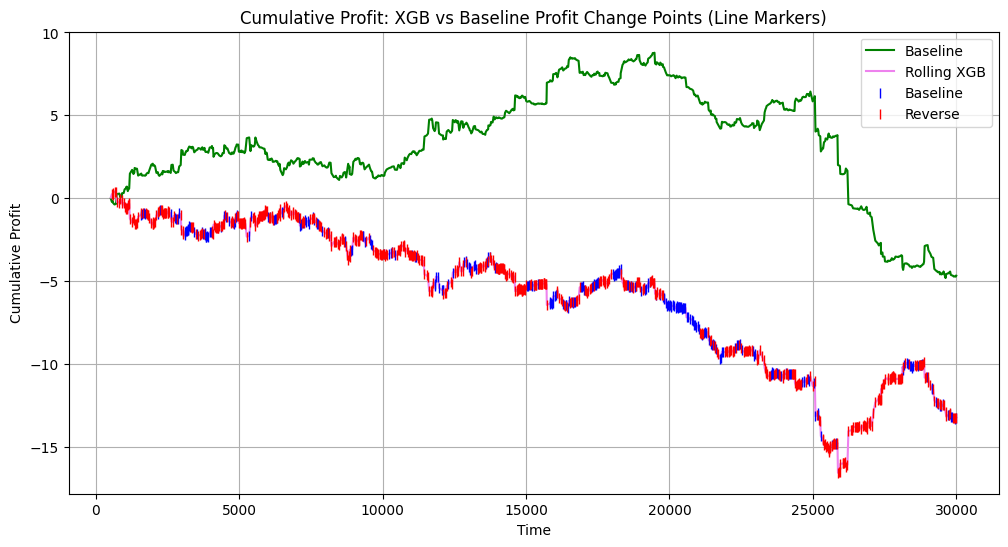

In [181]:
# --- Highlight points where the profit change (delta) differs between XGB and Baseline using line markers ---

# Calculate profit deltas (change from previous to current) for both strategies
xgb_deltas = np.diff(profits_xgb)
baseline_deltas = np.diff(profits_baseline)

# Align times for deltas (since np.diff reduces length by 1)
times_xgb_delta = times_xgb[1:]
times_baseline_delta = times_baseline[1:]

# Create mapping from time to delta for both strategies
xgb_time_delta = dict(zip(times_xgb_delta, xgb_deltas))
baseline_time_delta = dict(zip(times_baseline_delta, baseline_deltas))

# Find all unique times present in either delta series
all_times = sorted(set(times_xgb_delta) & set(times_baseline_delta))

# For each time, compare the profit deltas
same_times = []
same_deltas = []
diff_times = []
diff_deltas = []

xgb_time_profit = dict(zip(times_xgb, profits_xgb))

for t in all_times:
    xgb_d = xgb_time_delta.get(t, None)
    base_d = baseline_time_delta.get(t, None)
    if xgb_d is not None and base_d is not None:
        if xgb_d == base_d:
            same_times.append(t)
            same_deltas.append(xgb_time_profit[t])  # plot cumulative profit at this time
        else:
            diff_times.append(t)
            diff_deltas.append(xgb_time_profit[t])

plt.figure(figsize=(12, 6))
plt.plot(times_baseline, profits_baseline, label='Baseline', color='green')
plt.plot(times_xgb, profits_xgb, label='Rolling XGB', color='violet')
# Use line markers for same and different deltas
plt.scatter(same_times, same_deltas, color='blue', label='Baseline', s=60, marker='|', linewidths=1, zorder=5)
plt.scatter(diff_times, diff_deltas, color='red', label='Reverse', s=60, marker='|', linewidths=1, zorder=5)
plt.xlabel('Time')
plt.ylabel('Cumulative Profit')
plt.title('Cumulative Profit: XGB vs Baseline Profit Change Points (Line Markers)')
plt.legend()
plt.grid()
plt.show()

In [182]:
# # Parameter grid
# retrain_intervals = [150, 200, 250, 300, 350, 400]
# train_windows = [300, 400, 500, 600]

# # Store time series of profits
# spa_profits_over_time = {}

# for retrain_interval in retrain_intervals:
#     for train_window in train_windows:
#         print(f"\nRunning test with retrain_interval={retrain_interval}, train_window={train_window}")

#         # Use your predictor
#         rolling_pred_func = rolling_xgb_predictor(
#             df, feature_columns,
#             train_window=train_window,
#             retrain_interval=retrain_interval
#         )

#         # Run your simulation function
#         profits, times, total_profit, trade_count = simulate_trading_strategy(df, rolling_pred_func)

#         key = f"RI={retrain_interval}, TW={train_window}"
#         spa_profits_over_time[key] = (times, profits)

#         print(f"→ Final Profit: {total_profit:.2f}, Trades: {trade_count}")


In [183]:
# lower_threshold = 12
# upper_threshold = 20

# plt.figure(figsize=(10, 6))

# for label, (times, profits) in spa_profits_over_time.items():
#     final_profit = profits[-1]
#     if final_profit > lower_threshold and final_profit < upper_threshold:
#         plt.plot(times, profits, label=f"{label} (Profit={final_profit:.1f})")


# plt.plot(times_baseline, profits_baseline, label='Baseline', color = 'red')


# plt.xlabel("Time")
# plt.ylabel("Cumulative Profit")
# plt.title("SPA Configurations with Final Profit ")
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

In [184]:
# # --- Grid Search for Rolling XGBoost ---

# train_windows = [300, 400, 500, 600]
# retrain_intervals = [150, 200, 250, 300, 350, 400]

# best_profit = float('-inf')
# best_config = None
# results = []

# for tw in train_windows:
#     for ri in retrain_intervals:
#         print(f"Testing train_window={tw}, retrain_interval={ri}...")
#         rolling_pred_func = rolling_xgb_predictor(df, feature_columns, train_window=tw, retrain_interval=ri)
#         profits, times, total_profit, trade_count = simulate_trading_strategy(df, rolling_pred_func)
#         results.append((tw, ri, total_profit, trade_count))
#         if total_profit > best_profit:
#             best_profit = total_profit
#             best_config = (tw, ri)

# print("\nGrid Search Results:")
# for tw, ri, profit, trades in results:
#     print(f"train_window={tw}, retrain_interval={ri} -> Profit={profit:.2f}, Trades={trades}")

# print(f"\nBest configuration: train_window={best_config[0]}, retrain_interval={best_config[1]} with Profit={best_profit:.2f}")